In [79]:
import rasterio
from rasterio import warp
from rasterio.plot import show
from rasterio.mask import mask as riomask
from affine import Affine
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from rasterio.windows import Window
from affine import Affine
from sklearn.decomposition import PCA
import skimage
from skimage.exposure import match_histograms
import numpy as np
import geopandas as gpd

In [2]:
def trim_raster(data):
    """
    Parameters
    ----------
    data:
        A Rasterio-style numpy array (i.e., bands, rows, columns)
    
    Returns
    ------
    (1) the trimmed data...no nan values
    (2) the masked data array in Rasterio-style
    """
    
    bands, rows, cols = data.shape
    mask = np.isnan(data)
    mask = np.any(mask, axis=0)
    trimmed = data[:, ~mask].T
    
    return trimmed, np.invert(mask[np.newaxis, :])

In [3]:
def fill_trimmed_raster(data, mask, bands):
    """
    Parameters
    ----------
    data:
        A trimmed numpy array (i.e., the 'trimmed' output from trim_raster())
        
    mask:
        A mask of the original array (i.e., the 'mask' output from trim_raster())
    
    Returns
    ------
        The original data array in Rasterio-style (and nan's)
    """
    
#     b, rows, cols = mask.shape # b is thrown away, because it will always be 1 (if obtained from the trim_raster function). bands must represent the number of bands in the output image
    mask = mask[0, :, :]
    rows, cols = mask.shape
    output = np.empty((bands, rows, cols))
    output[:, :, :] = np.nan
    for b in range(bands):
        id = 0
        for r in range(rows):
            for c in range(cols):
                if mask[r, c]==True:
                    output[b, r, c] = data[id, b]
                    id+=1
    
    return output

## 0. Set input/output filenames

In [4]:
in_path = "./data/"
out_path = "./output/"

In [5]:
input_files = [in_path + i for i in ['t1011dc_nowtrS.img', 'toa8.img']]
output_files = [out_path + i for i in ['thermal_output.tif', 'toa_output.tif', 'hires.tif']]

In [49]:
doing_match = True

## 1. Clip to city boundary and rasterize water pixels to nan's

In [6]:
shape_src = gpd.read_file("./data/dc_water_mask2.geojson")

In [7]:
thermal_src = rasterio.open(input_files[0])
toa_src = rasterio.open(input_files[1])

In [8]:
thermal, thermal_transform = riomask(thermal_src, shape_src.geometry, crop=True)
toa, toa_transform = riomask(toa_src, shape_src.geometry, crop=True)
print(thermal.shape)
print(toa.shape)

(2, 691, 603)
(1, 1382, 1206)


In [9]:
t10 = thermal[0]
t11 = thermal[1]
print(t10.shape)
print(t11.shape)
t10up = t10.repeat(2, axis=0).repeat(2, axis=1)
t11up = t11.repeat(2, axis=0).repeat(2, axis=1)
print(t10up.shape)
print(t11up.shape)
thermal_upscaled = np.array([t10up, t11up])
print(thermal_upscaled.shape)

(691, 603)
(691, 603)
(1382, 1206)
(1382, 1206)
(2, 1382, 1206)


In [10]:
thermal = thermal_upscaled
print(thermal.shape)

(2, 1382, 1206)


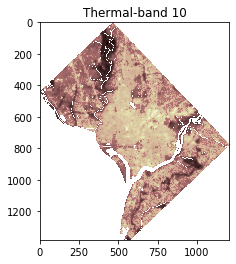

| 30.00, 0.00, 316327.50|
| 0.00,-30.00, 4318297.50|
| 0.00, 0.00, 1.00|


In [11]:
thermal[thermal==0] = np.nan
plt.title("Thermal-band 10")
plt.imshow(thermal[0], cmap='pink')
plt.show()
print(thermal_transform)

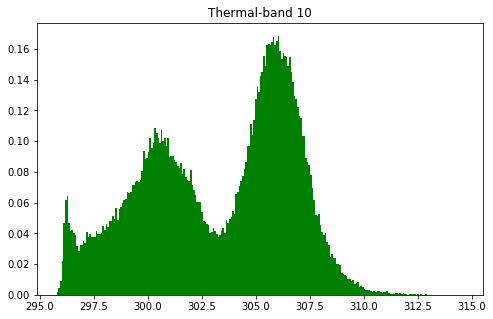

295.10616365109445
301.66171543150404


In [31]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))
n, bins, patches = plt.hist(thermal[0].flatten(), 250, density=True, facecolor='g')
plt.title("Thermal-band 10")
plt.show()
print(np.nanmin(thermal[:, 0]))
print(np.nanmax(thermal[:, 0]))

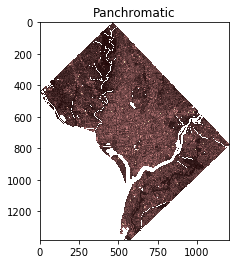

| 15.00, 0.00, 316327.50|
| 0.00,-15.00, 4318297.50|
| 0.00, 0.00, 1.00|


In [13]:
toa[toa==0] = np.nan
plt.title("Panchromatic")
plt.imshow(toa[0], cmap='pink')
plt.show()
print(toa_transform)

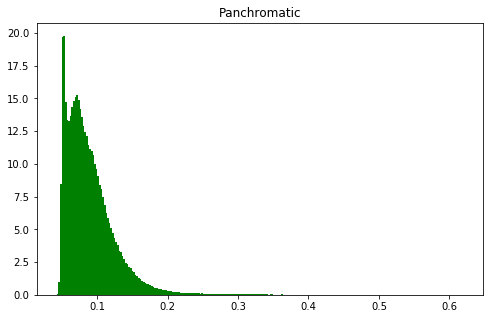

0.04278000000000001
0.6188800000000001


In [14]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))
n, bins, patches = axs.hist(toa[0].flatten(), 250, density=True, facecolor='g')
plt.title("Panchromatic")
plt.show()
print(np.nanmin(toa))
print(np.nanmax(toa))

In [15]:
matched = match_histograms(toa[0], thermal[0])
toa = matched[np.newaxis, :, :]
print(toa.shape)

(1, 1382, 1206)


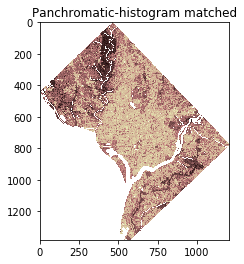

| 15.00, 0.00, 316327.50|
| 0.00,-15.00, 4318297.50|
| 0.00, 0.00, 1.00|


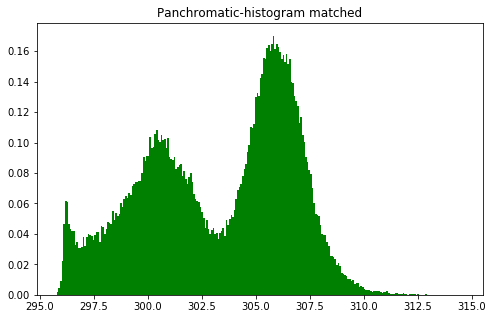

295.80312434709884
314.5790691540832


In [16]:
plt.title("Panchromatic-histogram matched")
plt.imshow(toa[0], cmap='pink')
plt.show()
print(toa_transform)
fig, axs = plt.subplots(1, 1, figsize=(8, 5))
n, bins, patches = axs.hist(toa[0].flatten(), 250, density=True, facecolor='g')
plt.title("Panchromatic-histogram matched")
plt.show()
print(np.nanmin(toa))
print(np.nanmax(toa))

In [17]:
print(toa_src.meta)
print(thermal_src.meta)

{'driver': 'HFA', 'dtype': 'float64', 'nodata': None, 'width': 15661, 'height': 15901, 'count': 1, 'crs': CRS.from_epsg(32618), 'transform': Affine(15.0, 0.0, 220792.5,
       0.0, -15.0, 4426507.5)}
{'driver': 'HFA', 'dtype': 'float64', 'nodata': None, 'width': 662, 'height': 746, 'count': 2, 'crs': CRS.from_epsg(32618), 'transform': Affine(30.0, 0.0, 315607.5,
       0.0, -30.0, 4319347.5)}


In [18]:
toa_meta = toa_src.meta
toa_meta.update(
    {"driver": "GTiff",
     "width": toa.shape[2],
     "height": toa.shape[1],
     "transform": toa_transform
    }     
)
print(toa_meta)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1206, 'height': 1382, 'count': 1, 'crs': CRS.from_epsg(32618), 'transform': Affine(15.0, 0.0, 316327.5,
       0.0, -15.0, 4318297.5)}


In [19]:
thermal_meta = thermal_src.meta
thermal_meta.update(
    {"driver": "GTiff",
     "width": thermal.shape[2],
     "height": thermal.shape[1],
     "transform": toa_transform
    }     
)
print(thermal_meta)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1206, 'height': 1382, 'count': 2, 'crs': CRS.from_epsg(32618), 'transform': Affine(15.0, 0.0, 316327.5,
       0.0, -15.0, 4318297.5)}


In [20]:
with rasterio.open(output_files[1], "w", **toa_meta) as dst:
    dst.write(toa[0], 1)

with rasterio.open(output_files[0], "w", **thermal_meta) as dst:
    dst.write(thermal[0], 1)
    dst.write(thermal[1], 2)

## 2. Trim away the nan's

In [21]:
thermal.shape

(2, 1382, 1206)

In [22]:
trimmed, mask = trim_raster(thermal)

In [23]:
print(trimmed)
print(trimmed.shape)

[[301.66171543 295.1754946 ]
 [301.66171543 295.1754946 ]
 [301.57028668 295.10616365]
 ...
 [296.22991943 290.99851955]
 [296.27621507 290.99475298]
 [296.27621507 290.99475298]]
(676668, 2)


In [24]:
print(mask)
print(mask.shape)
print(mask[mask==True].shape)

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]
(1, 1382, 1206)
(676668,)


In [25]:
toa_trimmed, toa_mask = trim_raster(toa)
print(toa_trimmed)
print(toa_trimmed.shape)
print(toa_mask)
print(toa_mask.shape)
print(toa_mask[mask==True].shape)

[[297.81237108]
 [297.46595871]
 [296.28504638]
 ...
 [298.94112537]
 [298.92286577]
 [298.77666558]]
(676668, 1)
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]
(1, 1382, 1206)
(676668,)


In [26]:
print(np.min(trimmed[:, 0]))
print(np.max(trimmed[:, 0]))
print(np.nanmean(trimmed[:, 0]))

295.80312434709884
314.5790691540832
303.271641494442


In [32]:
trimmed.shape

(676668, 2)

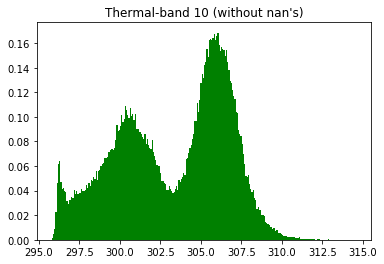

In [33]:
n, bins, patches = plt.hist(trimmed[:, 0], 250, density=True, facecolor='g')
plt.title("Thermal-band 10 (without nan's)")
plt.show()

In [34]:
print(np.min(trimmed[:, 1]))
print(np.max(trimmed[:, 1]))

290.87039428810806
305.56028688231265


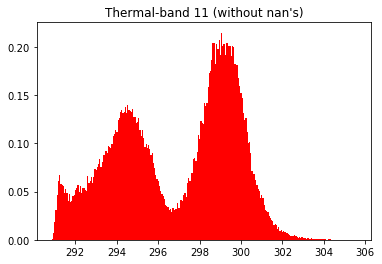

In [35]:
n, bins, patches = plt.hist(trimmed[:, 1], 250, density=True, facecolor='r')
plt.title("Thermal-band 11 (without nan's)")
plt.show()

In [86]:
# z = gaussian_kde(trimmed[:, 0])(trimmed[:, 0])
# idx = z.argsort()
# x, y, z = x[idx], y[idx], z[idx]

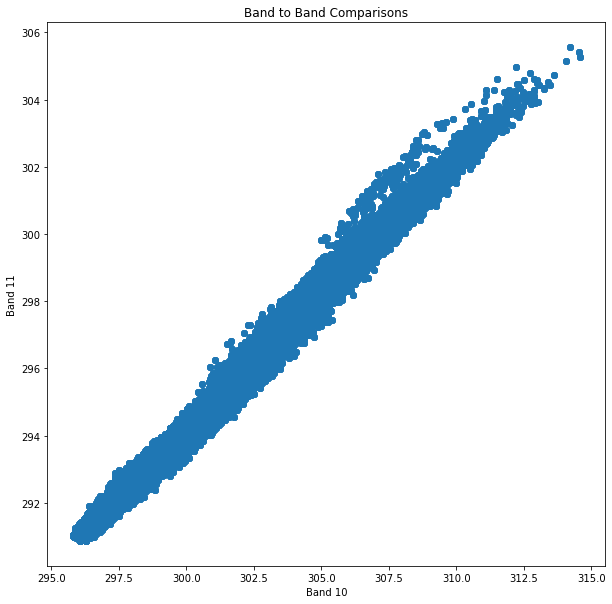

In [87]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.set_title("Band to Band Comparisons")
axs.set_xlabel("Band 10")
axs.set_ylabel("Band 11")
axs.scatter(trimmed[:, 0], trimmed[:, 1])

## 3. Perform Principal Components Analysis

In [37]:
pca = PCA(n_components=2)

In [38]:
trimmed.shape

(676668, 2)

In [39]:
pc = pca.fit_transform(trimmed)

In [40]:
print(pca.explained_variance_ratio_) 

[0.99829798 0.00170202]


In [41]:
print(pca.explained_variance_) 

[19.74085027  0.03365655]


In [42]:
print(pca.components_)

[[ 0.76939783  0.6387699 ]
 [-0.6387699   0.76939783]]


In [43]:
pc.shape

(676668, 2)

In [44]:
print(np.min(pc[:, 0]))
print(np.max(pc[:, 0]))

-9.483810918459358
14.135438273976627


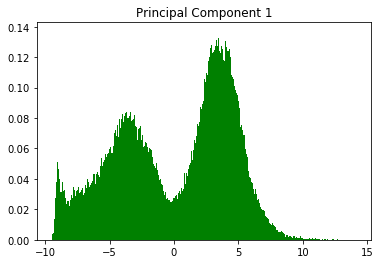

In [45]:
n, bins, patches = plt.hist(pc[:, 0], 500, density=True, facecolor='g')
plt.title("Principal Component 1")
plt.show()

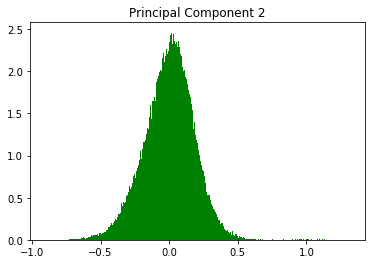

In [46]:
n, bins, patches = plt.hist(pc[:, 1], 500, density=True, facecolor='g')
plt.title("Principal Component 2")
plt.show()

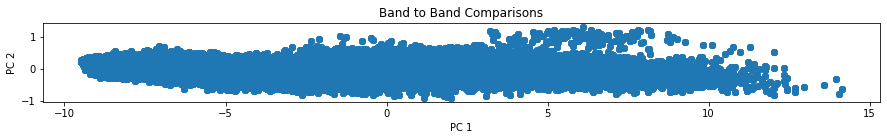

In [47]:
fig, axs = plt.subplots(1, 1, figsize=(15, 15))
axs.set_title("Band to Band Comparisons")
axs.set_xlabel("PC 1")
axs.set_ylabel("PC 2")
plt.gca().set_aspect('equal', adjustable='box')
axs.scatter(pc[:, 0], pc[:, 1])

## 4. Scale panchromatic band to the thermal range and perform inverse PCA mapping

In [61]:
print(toa_trimmed.shape)
toa2 = np.copy(toa_trimmed)
pc_min = np.min(pc[:, 0])
pc_max = np.max(pc[:, 0])
pc_range = pc_max - pc_min
toa_min = np.nanmin(toa2)
    
if not doing_match:
    # (Un)comment one of the following 2 lines
    toa_max = np.nanmax(toa2)
    # toa_max = 0.15 # 35, 25, 20, 17
else:
    toa_max = np.nanmax(toa2)

toa_range = toa_max - toa_min
toa2[toa2 <= toa_min] = toa_min
toa2[toa2 >= toa_max] = toa_max
pan_stretched = (toa2 - toa_min) / toa_range * pc_range + pc_min
print(np.nanmin(pan_stretched))
print(np.nanmax(pan_stretched))
print(pan_stretched.shape)

(676668, 1)
-9.483810918459358
14.135438273976629
(676668, 1)


In [62]:
pan_stretched.shape

(676668, 1)

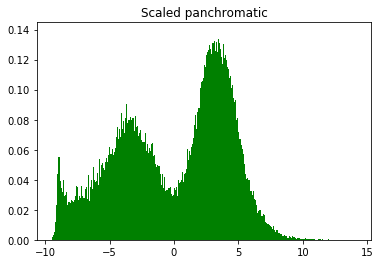

In [63]:
n, bins, patches = plt.hist(pan_stretched.flatten(), 500, density=True, facecolor='g')
plt.title("Scaled panchromatic")
plt.show()

In [64]:
p = pan_stretched.flatten().T
t = pc[:, 1].flatten().T

X = np.array([p, t]).T

print(p.shape)
print(t.shape)
print(X.shape)

(676668,)
(676668,)
(676668, 2)


In [65]:
hires = pca.inverse_transform(X)
print(hires.shape)

(676668, 2)


In [66]:
print(np.nanmin(hires[:, 0]))
print(np.nanmax(hires[:, 0]))

295.50780777156336
314.3413062975067


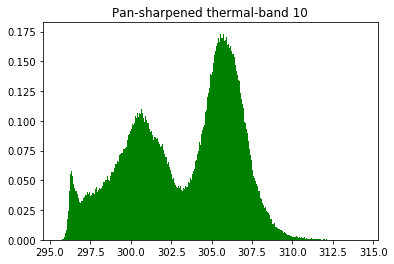

In [67]:
n, bins, patches = plt.hist(hires[:, 0].flatten(), 500, density=True, facecolor='g')
plt.title("Pan-sharpened thermal-band 10")
plt.show()

In [68]:
print(np.nanmin(hires))
print(np.nanmax(hires))
print(np.nanmean(hires))

290.54252470951076
314.3413062975067
300.00770680481315


In [69]:
print(mask.shape)

(1, 1382, 1206)


## 5. Map back to band, row, column

In [70]:
filled = fill_trimmed_raster(hires, mask, 2)

In [71]:
print(hires.shape)
print(filled.shape)

(676668, 2)
(2, 1382, 1206)


/home/nate/anaconda3/envs/vs-jupyter-histmatch/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/nate/anaconda3/envs/vs-jupyter-histmatch/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


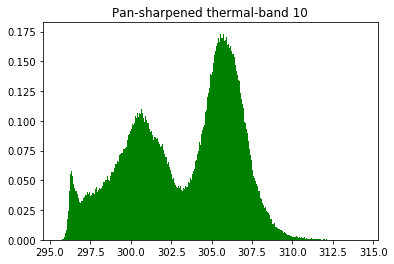

In [72]:
n, bins, patches = plt.hist(filled[0].flatten(), 500, density=True, facecolor='g')
plt.title("Pan-sharpened thermal-band 10")
plt.show()

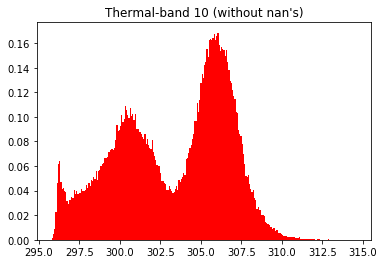

In [73]:
n, bins, patches = plt.hist(trimmed[:, 0], 250, density=True, facecolor='r')
plt.title("Thermal-band 10 (without nan's)")
plt.show()

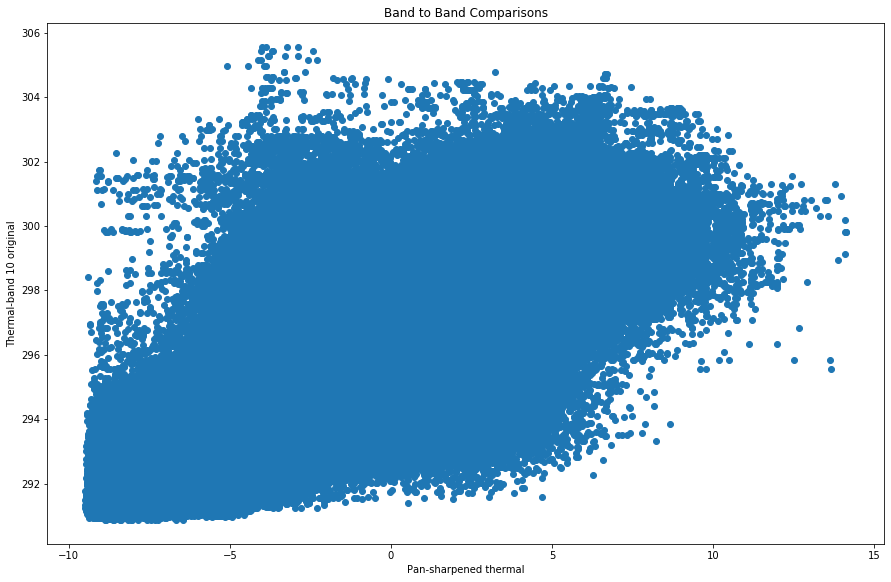

In [74]:
fig, axs = plt.subplots(1, 1, figsize=(15, 15))
axs.set_title("Band to Band Comparisons")
axs.set_xlabel("Pan-sharpened thermal")
axs.set_ylabel("Thermal-band 10 original")
plt.gca().set_aspect('equal', adjustable='box')
axs.scatter(X[:, 0], trimmed[:, 1])

In [76]:
np.corrcoef(X[:, 0], trimmed[:, 0])[0, 1]

0.7985155299037494

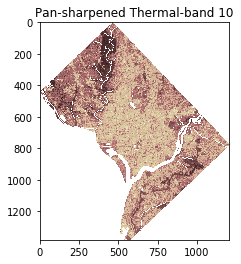

In [77]:
plt.title("Pan-sharpened Thermal-band 10")
plt.imshow(filled[0], cmap='pink')
plt.show()

In [78]:
with rasterio.open(
    output_files[2],
    'w',
    **thermal_meta
) as dst:
    dst.write(filled)